In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import gaussian_process as gp
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, ConstantKernel as C
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

from george import kernels
import george
from functions import *

In [47]:
info = pd.read_csv('lc_example/OGLE_Roman_field_variables.CSV')

In [66]:
i = info.index[info.ID == 'OGLE-BLG-LPV-048414']
ID = info.ID[i].values[0]
period = info.P_1[i].values[0]
df = read_OGLE_lc(ID, period)

In [67]:
df_large_gaps = find_large_gaps(df)

Text(0, 0.5, 'Magnitude in I band')

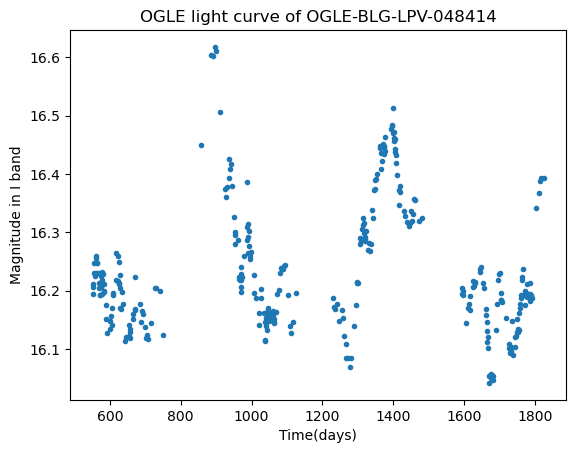

In [68]:
plt.plot(df.t, df.m, '.')
plt.title('OGLE light curve of %s'%ID)
plt.xlabel('Time(days)')
plt.ylabel('Magnitude in I band')

In [69]:
df_gapped, df, p = gap_remover(ID, period)

/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/Roman_lc_gen/functions.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)


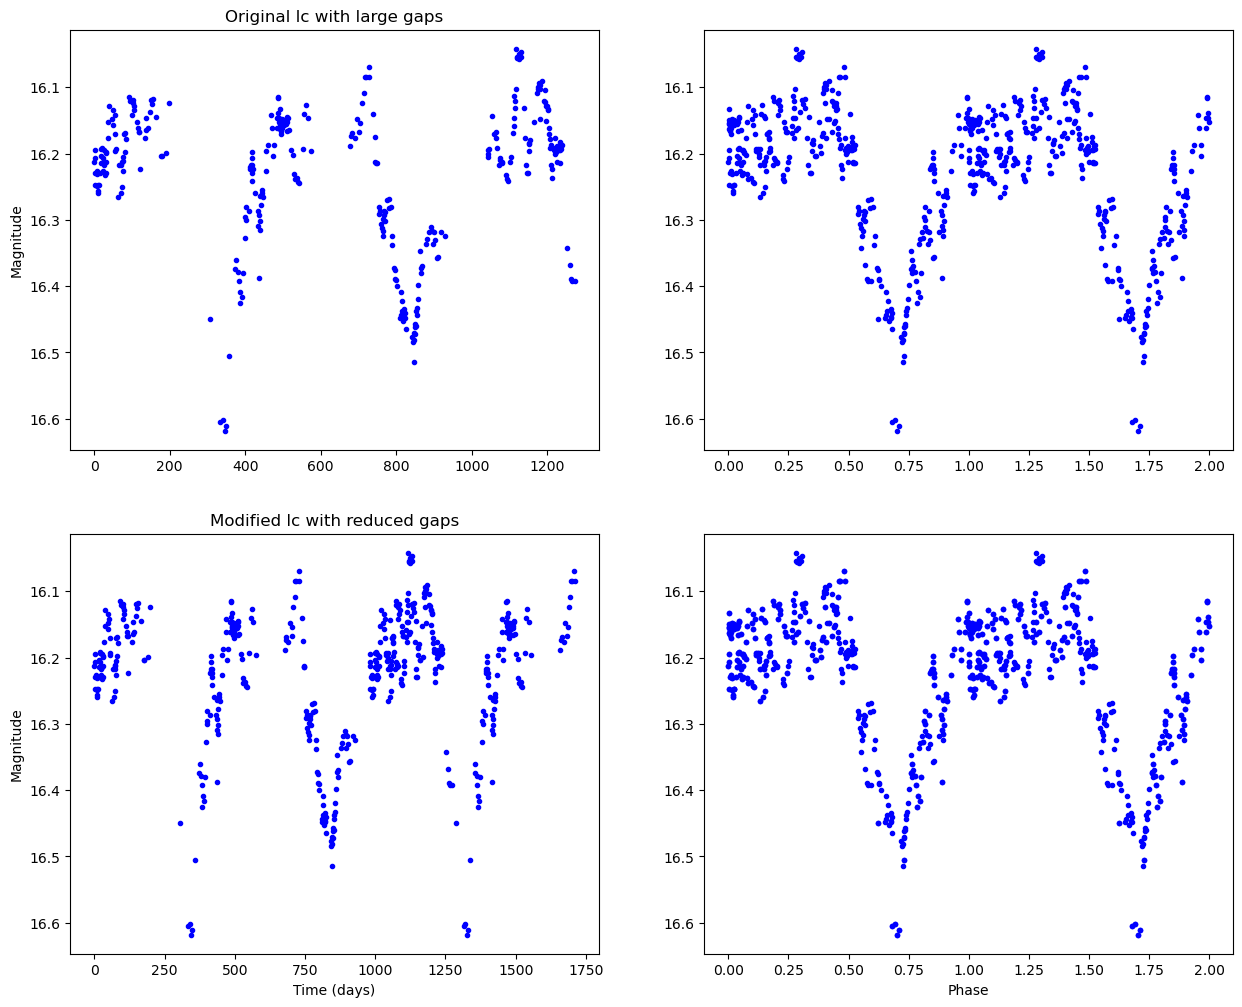

In [70]:
fig, axs = plt.subplots(2, 2)




axs[0,0].plot(df_gapped.t, df_gapped.m,'b.')
axs[0,1].plot(df_gapped.phase, df_gapped.m,'b.')
axs[0,1].plot(df_gapped.phase+1, df_gapped.m,'b.')

axs[1,0].plot(df.t, df.m,'b.')
axs[1,1].plot(df.phase, df.m,'b.')
axs[1,1].plot(df.phase+1, df.m,'b.')



axs[0,0].invert_yaxis()
axs[0,1].invert_yaxis()
axs[1,1].invert_yaxis()
axs[1,0].invert_yaxis()

axs[0,0].set_ylabel('Magnitude')
axs[0,0].set_title('Original lc with large gaps')
axs[1,0].set_ylabel('Magnitude')
axs[1,0].set_title('Modified lc with reduced gaps')

axs[1,0].set_xlabel('Time (days)')
axs[1,1].set_xlabel('Phase')




fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# plt.savefig('OGLE_lc_reducing_gaps_in_full_lc.png',facecolor='white', edgecolor='none')

In [71]:
kernel = kernels.CosineKernel(np.log(period))+kernels.Matern32Kernel(1500000)
    
gp = george.GP(kernel, solver= george.HODLRSolver)

# Pre-compute the factorization of the matrix.
gp.compute(df.t, df.e.values)

t_new = np.loadtxt('lc_example/ulwdc1_208_W149.txt', usecols=0)
t_new = t_new - min(t_new)

t_prime = np.linspace(0, max(t_new),1000)
    
median_m = np.median(df.m)
mu, cov = gp.predict(df.m-median_m, t_prime)
std = np.sqrt(np.diag(cov))

intpl = interp1d(t_prime, mu)
m_new = intpl(t_new)


noise_fun = noise_function('cycle6_snr_curve.txt')
mu_err = noise_fun(m_new+median_m)




df_new = pd.DataFrame({'t': t_new, 'm': m_new , 'e': mu_err})

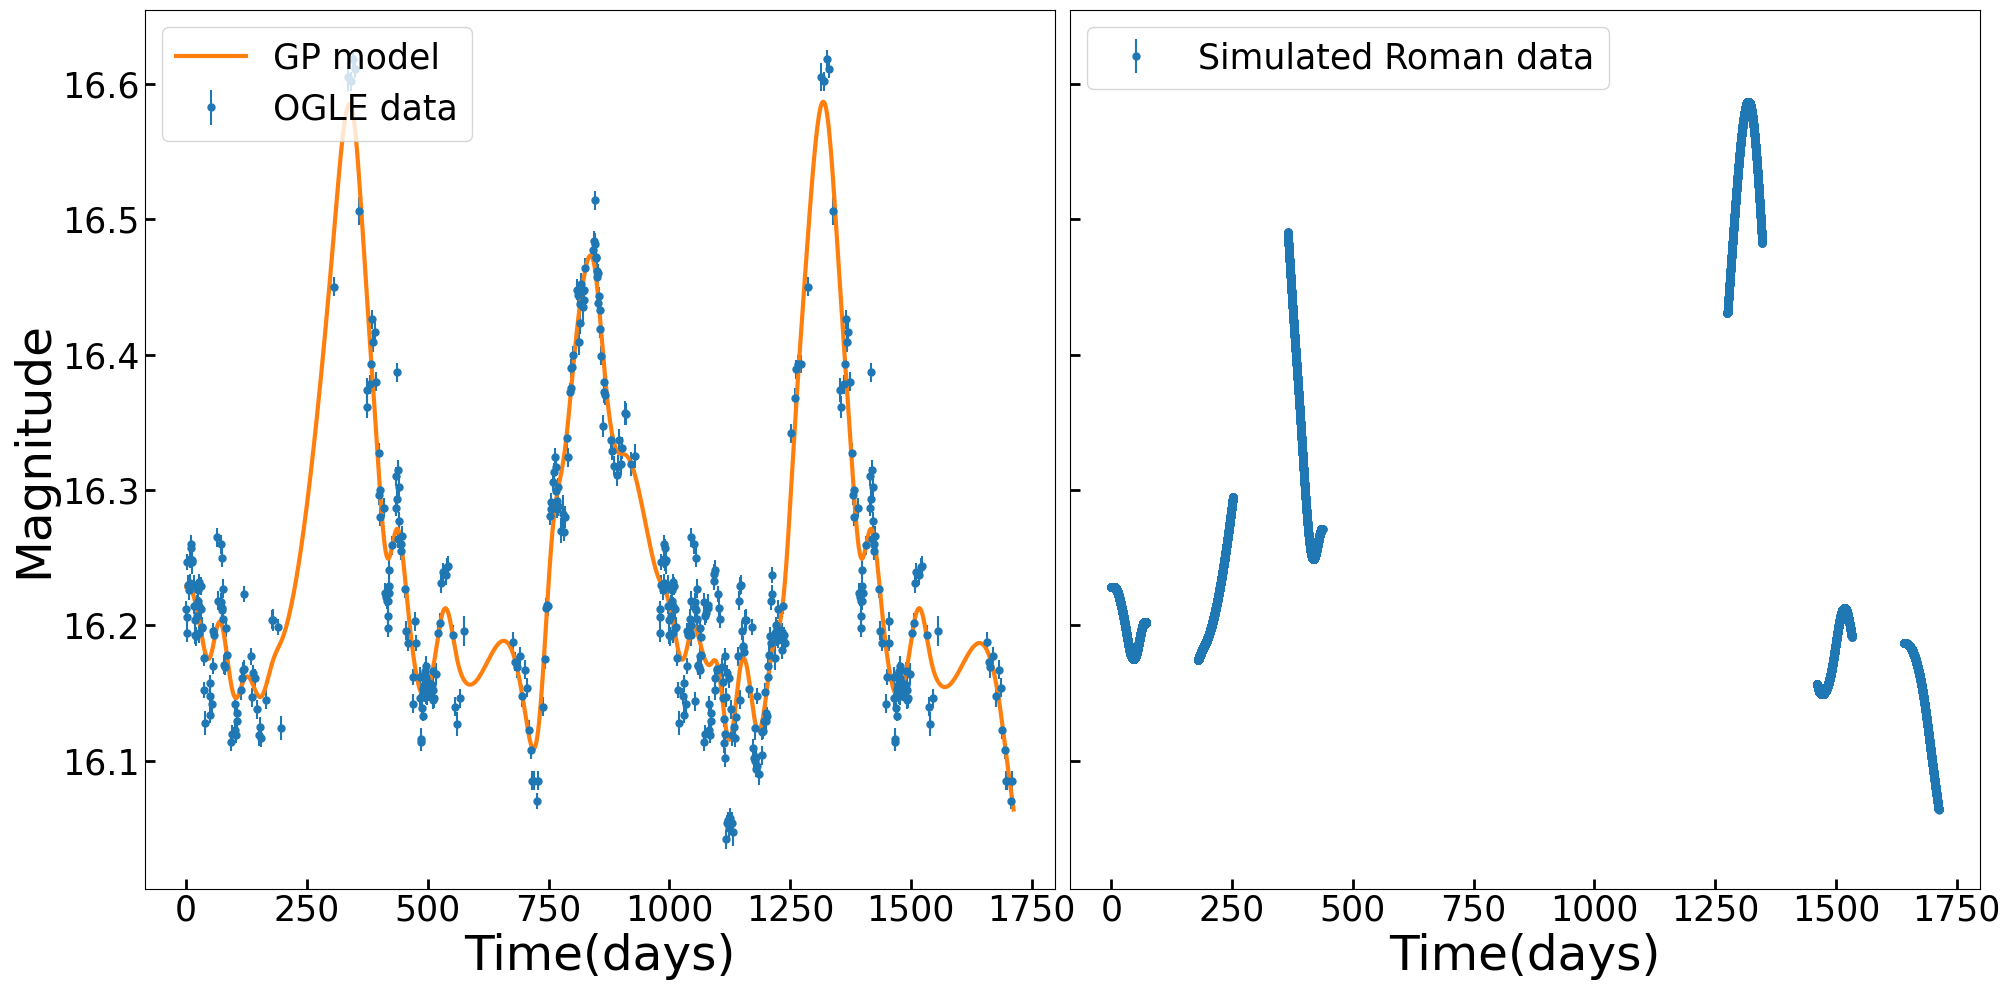

In [72]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)

# ax[0].errorbar(df_gapped.t, df_gapped.m, yerr=df_gapped.e, fmt = '.', ms=10, label='OGLE data')
# ax[0].plot(np.linspace(0, max(t_prime),1000), intpl(np.linspace(0, max(t_prime),1000)), label='GP model', linewidth=3)


ax[0].errorbar(df.t, df.m,yerr=df.e, fmt = '.', ms=10, label='OGLE data')
ax[0].plot(t_prime, mu+median_m, label='GP model', linewidth=3)
ax[0].set_xlabel('Time(days)', size=35)
ax[0].set_ylabel('Magnitude', size=35)
# plt.title(info.ID[i], size=25)
ax[0].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[0].legend(loc = 2,prop={'size':25})


ax[1].errorbar(df_new.t, df_new.m+median_m,yerr=df_new.e, fmt = '.', ms=10, label='Simulated Roman data')
# plt.plot(t_prime, mu, label='GP model', linewidth=3)
ax[1].set_xlabel('Time(days)', size=35)
# ax[1].set_ylabel('Magnitude', size=35)
# plt.title(info.ID[i], size=25)
ax[1].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[1].legend(loc = 2,prop={'size':25})
fig.tight_layout()
# plt.savefig('OGLE_Roman_full_lc_with_GP_model.jpg',facecolor='white', edgecolor='none', bbox_inches='tight')

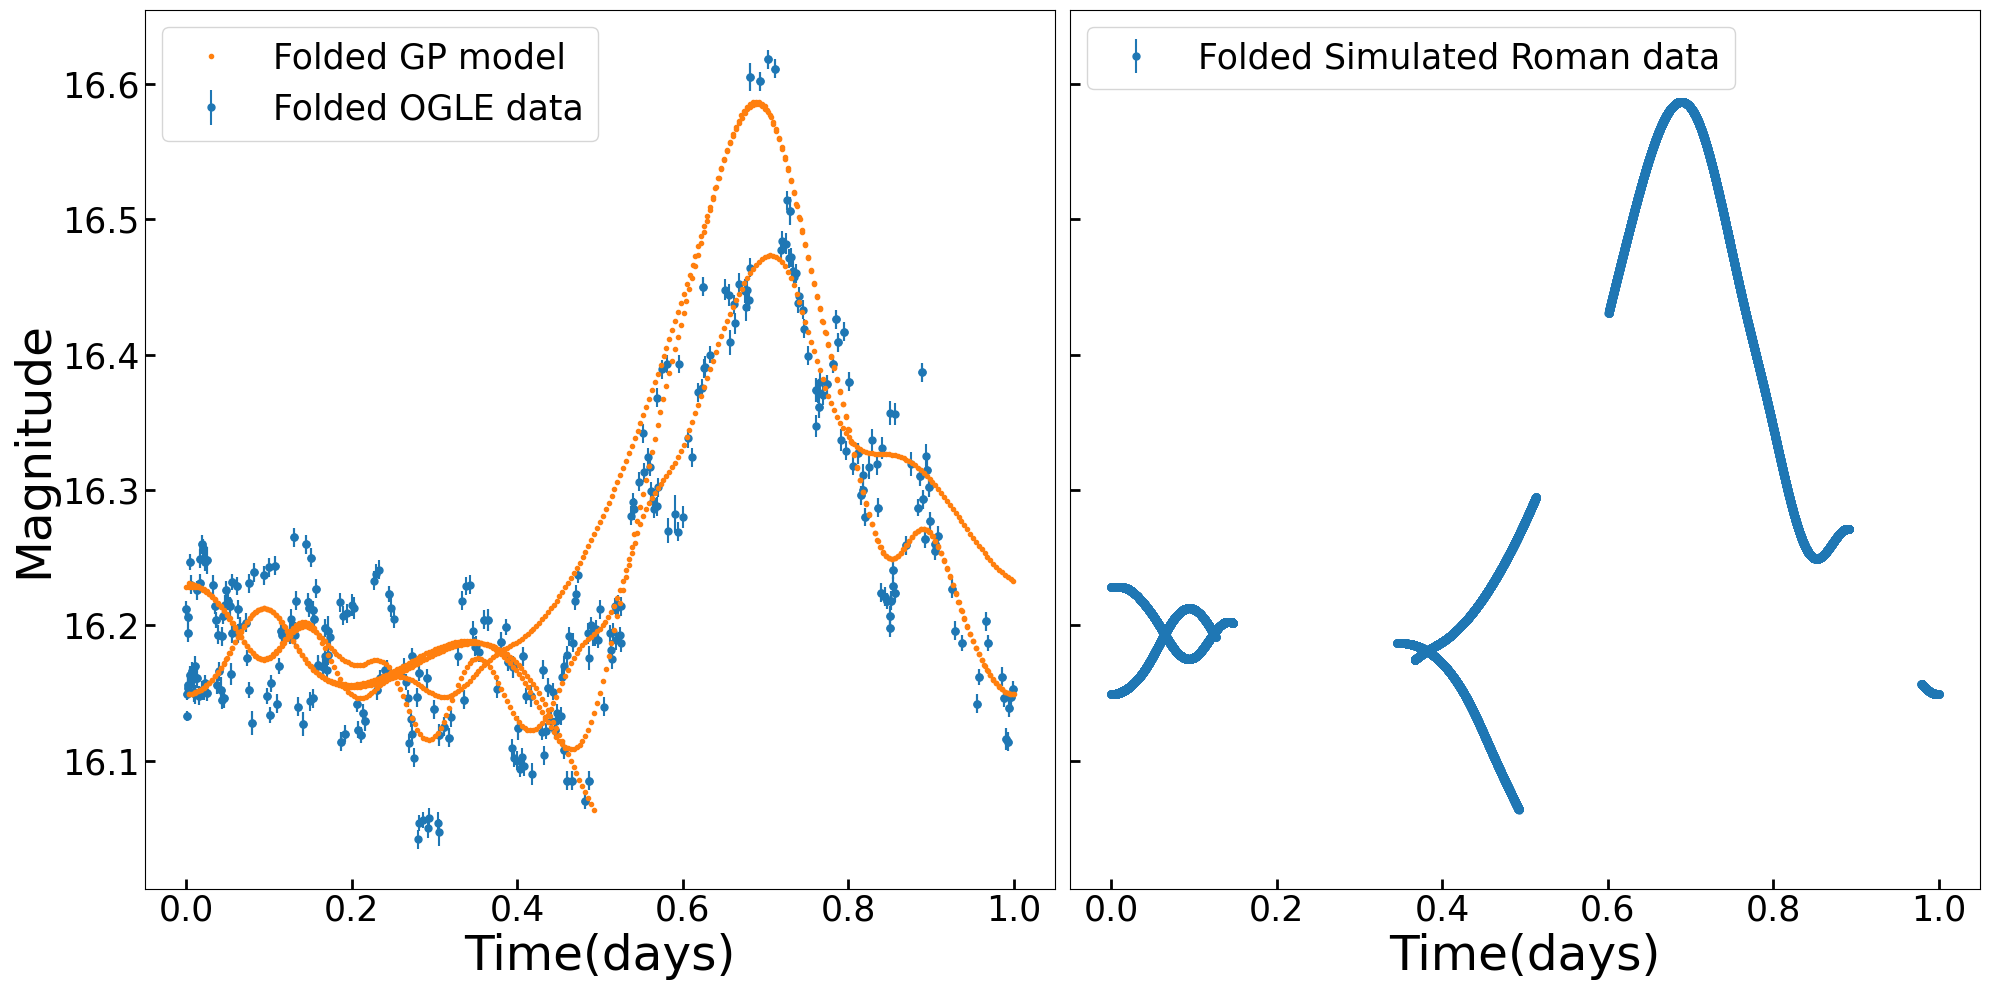

In [73]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)

# ax[0].errorbar(df_gapped.phase, df_gapped.m, yerr=df_gapped.e, fmt = '.', ms=10, label='OGLE data')
# ax[0].plot((np.linspace(0, max(t_prime),1000)/period)%1, 
#            intpl(np.linspace(0, max(t_prime),1000)), '.',
#            label='GP model', zorder=11)


ax[0].errorbar(df.phase, df.m,yerr=df.e, fmt = '.', ms=10, label='Folded OGLE data')
ax[0].plot((t_prime/period)%1, mu+median_m, '.', label='Folded GP model', zorder=11)
ax[0].set_xlabel('Time(days)', size=35)
ax[0].set_ylabel('Magnitude', size=35)
# plt.title(info.ID[i], size=25)
ax[0].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[0].legend(loc = 2,prop={'size':25})


ax[1].errorbar((df_new.t/period)%1, df_new.m+median_m,yerr=df_new.e, fmt = '.', ms=10, label='Folded Simulated Roman data')
# plt.plot((t_prime/period)%1, mu, '.', label='GP model', zorder=11)
ax[1].set_xlabel('Time(days)', size=35)
# ax[1].set_ylabel('Magnitude', size=35)
# plt.title(info.ID[i], size=25)
ax[1].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[1].legend(loc = 2,prop={'size':25})
fig.tight_layout()
# plt.savefig('OGLE_Roman_full_lc_with_GP_model.jpg',facecolor='white', edgecolor='none', bbox_inches='tight')

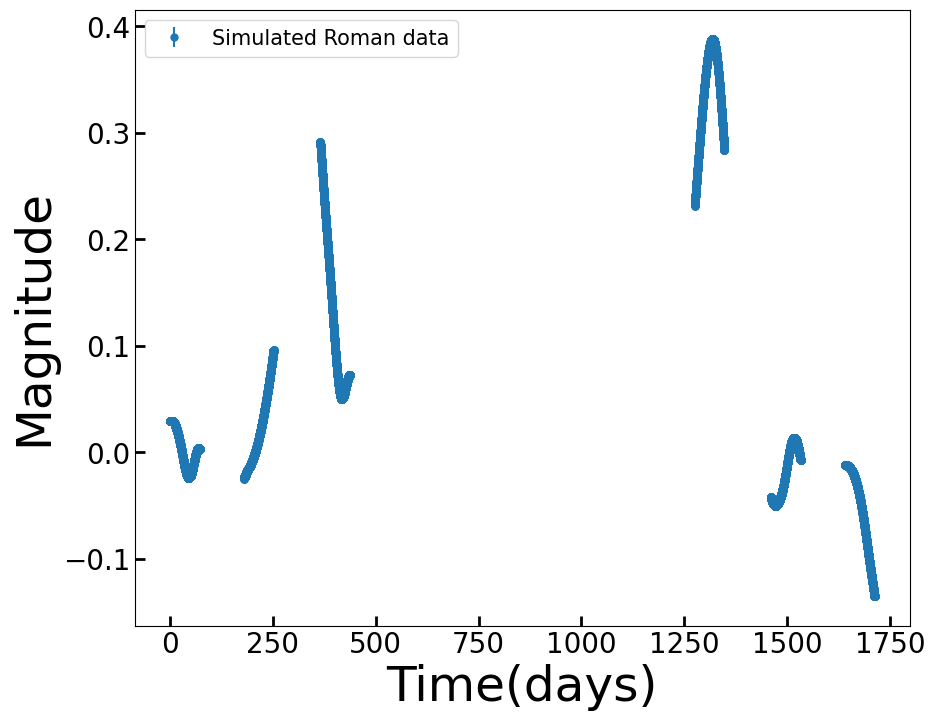

In [74]:
plt.figure(figsize=(10,8))


plt.errorbar(df_new.t, df_new.m,yerr=df_new.e, fmt = '.', ms=10, label='Simulated Roman data')
# plt.plot(t_prime, mu, label='GP model', linewidth=3)
plt.xlabel('Time(days)', size=35)
plt.ylabel('Magnitude', size=35)
# plt.title(info.ID[i], size=25)
plt.gca().tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=20, width = 2)
plt.legend(prop={'size':15})
# plt.savefig('OGLE_full_in_Roman_sampling.pdf',facecolor='white', edgecolor='none', bbox_inches='tight')